# MIS 583 Assignment 6: Text Sentiment Classification with Prompt Learning

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 池品叡, B094020030

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive or negative based on the emotions customers express within them.

In Task 1, you need to fine-tune a pre-trained language model (e.g., BERT) to predict the sentiment of given tweets.

In Task 2, we employ prompts to enable the model to perform sentiment analysis through in-context learning, eliminating the need for additional training.

In Task 3, you will use the method called LM-BFF to utilize the model in generating the optimal template and verbalizer autonomously.


# Notice 
**You are not allow to use the model like GPT family or pre-trained weight using SST-2 and twitter dataset!!!!!!!!!!!!!!!!!**

You can use BERT and RoBERTa encoder model

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [52]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
torch 2.1.0+cu121
torchvision 0.16.0+cpu


# Task 1: Text Sentiment Classification (40 points)

In this task, you need to fine-tune a pre-trained language model (e.g., BERT or RoBERTa encoder) to predict the sentiment of given tweets.


## Loading Model and Data

First, let's talk about the model. The Hugging Face team has created an amazing framework called "transformers" for NLP tasks. It includes many state-of-the-art machine learning models for PyTorch, TensorFlow, and JAX.

To start with this package, follow [this link to installation and a basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [53]:
## you might need some additional installations there
#%echo happy installation
#%pip -V
#%pip install grpcio
#%pip install google-auth
#%pip install protobuf==3.9.2
#%pip install pyprind
#%pip install tqdm boto3 requests regex sentencepiece sacremoses

In [54]:
from torch import nn

#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
# from transformers import xxx
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification 
bert_type = 'bert-base-uncased'


# ---------- 1. load from torch.hub ----------
tokenizer_hub = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', bert_type)

# create a Bert-extended task (classification)
model1 = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', bert_type)

# ---------- 2. load from installed huggingface ----------
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# create a Bert-extended task (classification)
model2 = RobertaForSequenceClassification.from_pretrained('roberta-base')

# finetune from the output from bert to your task
model1.classifier = nn.Linear(768, 3, bias=True)
model2.classifier.out_proj = nn.Linear(768, 3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################

Using cache found in C:\Users\Chi/.cache\torch\hub\huggingface_pytorch-transformers_main
Using cache found in C:\Users\Chi/.cache\torch\hub\huggingface_pytorch-transformers_main
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1317** 筆資料.  
Testing set 有 **3075** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import csv

# Loading the dataset

In [55]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []

    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

## DataLoader 1

In [56]:
from torch.utils.data import Dataset, DataLoader
class TwitterDataset_1(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer_hub(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

## DataLoader 2

In [57]:
from torch.utils.data import Dataset, DataLoader
class TwitterDataset_2(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = roberta_tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

## `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [61]:
dataset_train1 = TwitterDataset_1(mode='train')
dataset_val1 = TwitterDataset_1(mode='val')
dataset_test1 = TwitterDataset_1(mode='test')


batch_size = 64
train_data1 = DataLoader(dataset_train1, batch_size=batch_size,
                       shuffle=True)
val_data1 = DataLoader(dataset_val1, batch_size=batch_size // 2,
                       shuffle=False)
test_data1 = DataLoader(dataset_test1, batch_size=batch_size // 2,
                       shuffle=False)


mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [62]:
dataset_train2 = TwitterDataset_2(mode='train')
dataset_val2 = TwitterDataset_2(mode='val')
dataset_test2 = TwitterDataset_2(mode='test')

batch_size = 64
train_data2 = DataLoader(dataset_train2, batch_size=batch_size,
                       shuffle=True)
val_data2 = DataLoader(dataset_val2, batch_size=batch_size // 2,
                       shuffle=False)
test_data2 = DataLoader(dataset_test2, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [63]:
t1 = tokenizer_hub.convert_ids_to_tokens(dataset_train1[0][0]) # converts a sequence of numeric IDs in the training dataset into their corresponding tokens using the specified tokenizer.
print('token', t1)
print('token to s', tokenizer_hub.convert_tokens_to_string(t1)) # converts a sequence of tokens (t) back into the original text string using the specified tokenizer.
t2 = roberta_tokenizer.convert_ids_to_tokens(dataset_train1[0][0]) # converts a sequence of numeric IDs in the training dataset into their corresponding tokens using the specified tokenizer.
print('token', t2)
print('token to s', roberta_tokenizer.convert_tokens_to_string(t2)) # converts a sequence of tokens (t) back into the original text string using the specified tokenizer.

token ['[CLS]', '@', 'united', 'i', 'have', 'never', 'been', 'mis', '##lea', '##d', 'by', 'a', 'company', 'as', 'many', 'times', 'as', 'i', 'have', 'this', 'week', 'by', 'united', 'airlines', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
token to s [CLS] @ united i have never been mislead by a company as many times as i have this week by united airlines! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
token ['Ġlike', 'Ġlegal', 'Ġsend', 'Ġcreate', 'Ġchoice

# Define loss and optimizer

In [64]:
device = torch.device('cuda')

from torch import nn

optimizer1 = optim.AdamW(model1.parameters(), lr=1e-5) # AdamW optimizer(torch.optim version of the Adam algorithm with weight decay fix)
criterion1 = nn.CrossEntropyLoss()

model1 = model1.to(device)
criterion1 = criterion1.to(device)

# Second model
optimizer2 = optim.AdamW(model2.parameters(), lr=1e-5) # AdamW optimizer(torch.optim version of the Adam algorithm with weight decay fix)
criterion2 = nn.CrossEntropyLoss()

model2 = model2.to(device)
criterion2 = criterion2.to(device)

# Utility Function

In [65]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

# Train function

In [89]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. Clean the gradients of optimizer
        # 2. Put correct variables into model
        # 3. Get prediction
        # 4. Evalutate by criterion and accuracy
        optimizer.zero_grad()
        outputs = model(text, attention_mask=mask)

        loss = criterion(outputs[0], label)
        acc = accuracy(outputs[0], label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, optimizer, criterion, log_loss=False):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. Put correct variables into model
        # 2. Get prediction
        # 3. Evalutate by criterion and accuracy
        optimizer.zero_grad()
        outputs = model(text, attention_mask=mask)

        loss = criterion(outputs[0], label)
        acc = accuracy(outputs[0], label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)

    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

# Start Training

## Train Process 1

In [90]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 5
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model1, train_data1, optimizer1, criterion1)
    val_loss, val_acc = test(model1, val_data1, optimizer1, criterion1, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))

    m.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    torch.save(model1.state_dict(), 'ckpts/e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model1
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

 32%|███▏      | 51/161 [00:10<00:22,  4.95it/s]


KeyboardInterrupt: 

## Train Process 2

In [ ]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 5
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m2 = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model2, train_data2, optimizer2, criterion2)
    val_loss, val_acc = test(model2, val_data2, optimizer2, criterion2, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))

    m2.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    torch.save(model2.state_dict(), 'ckpts/e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model2
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 42/42 [00:01<00:00, 34.31it/s]


Epoch 1 train_loss: 0.009763552621879399 train_acc: 0.737607338017174
Epoch 1 val_loss:  0.01264980362393047 val_acc : 0.8466211085801063
---------- e 1 save best model ----------


100%|██████████| 42/42 [00:01<00:00, 35.06it/s]


Epoch 2 train_loss: 0.006091615471590505 train_acc: 0.850800156128025
Epoch 2 val_loss:  0.012126238155337836 val_acc : 0.8549734244495064
---------- e 2 save best model ----------


100%|██████████| 42/42 [00:01<00:00, 35.03it/s]


Epoch 3 train_loss: 0.005027634756905692 train_acc: 0.8766588602654176
Epoch 3 val_loss:  0.012903410983791655 val_acc : 0.8435839028094153


100%|██████████| 42/42 [00:01<00:00, 33.82it/s]


Epoch 4 train_loss: 0.004276843284235672 train_acc: 0.9007611241217799
Epoch 4 val_loss:  0.012816716143232045 val_acc : 0.8580106302201974
---------- e 4 save best model ----------


100%|██████████| 42/42 [00:01<00:00, 33.68it/s]


Epoch 5 train_loss: 0.003512743624199144 train_acc: 0.9181303669008587
Epoch 5 val_loss:  0.013047548576668979 val_acc : 0.8640850417615793
---------- e 5 save best model ----------


### Plot the MODEL1 loss and accuracy curve ###

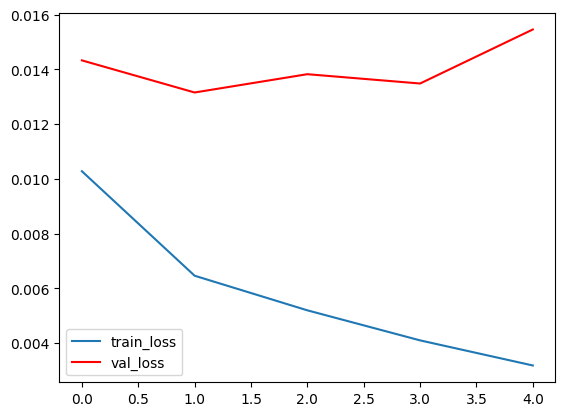

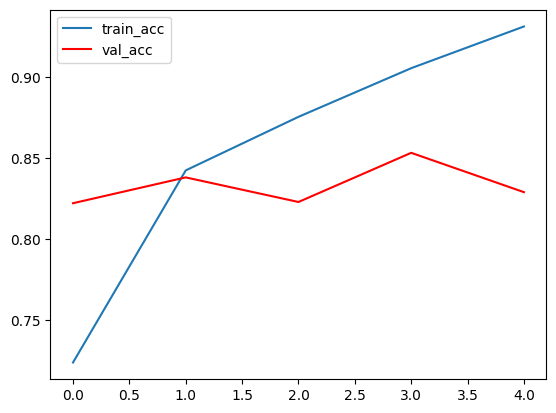

In [15]:
# plot them out
m.plot()

### Plot the MODEL2 acc and loss curve

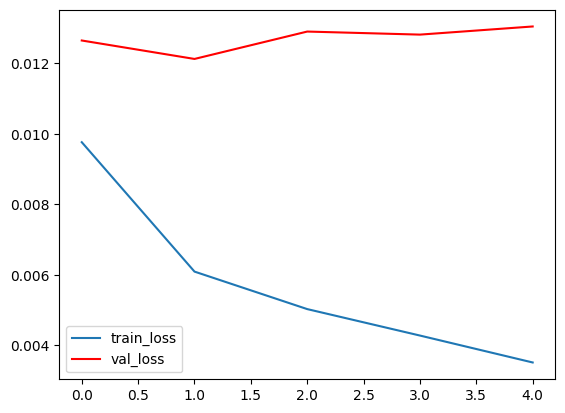

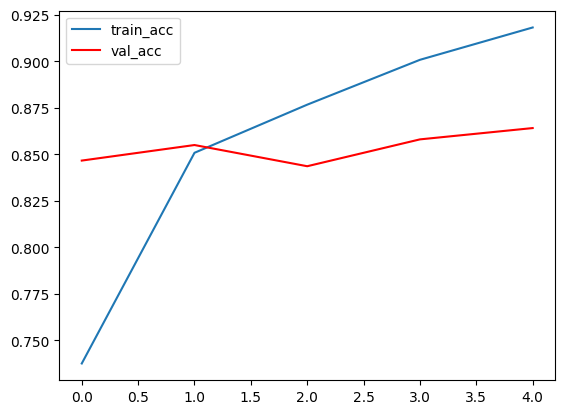

In [16]:
m2.plot()

# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/f072e95f51bc48978225941dba218241).


In [20]:
from json import load

#best_model = model1
#best_model = model2
#best_model.load_state_dict(torch.load('ckpts/e5.pt'))

In [21]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data1, total=len(test_data1)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 97/97 [00:02<00:00, 32.48it/s]


# Task 2: In-Context learning (32 points)

In this task, you will learn how to perform sentiment classification using **prompts** without the need for training.

In [1]:
import torch
import pyprind
import numpy as np
import pandas as pd
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForMaskedLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
print(torch.cuda.is_available())

True


## Loading model and setup

In [2]:
#########################################################################
#         TODO: Design your own template(prefix) and verbalizer         #
#########################################################################
class Config:
    def __init__(self):
        
        self.prefix = (
            "Example 1: Sentence: 'So excited I was put on an earlier flight to get home! Woo Hoo! #travel 🎉🎉🎉' Sentiment: 'positive'\n"
            "Example 2: Sentence: 'Just signed up for TrueBlue and booked a flight but keep getting an error when I try to link it to my TB account. What's the deal?' Sentiment: 'neutral'.\n"
            "Example 3: Sentence: 'Filed a PIR with an agent at Indianapolis airport. Unable to pull up information online on your site. Have DMed details.' Sentiment: 'negative'\n"
            "Example 4: Sentence: 'Can't believe you have to pay money to be treated this poorly.' Sentiment: 'negative'\n"
            "Determine the sentiment of the following sentence: '[MASK]'"
            )
        self.verbalizer = {
            'terrible': 0,
            'average': 1,
            'wonderful': 2,
        }
        
        self.max_seq_length = 512
        self.batch_size = 64


config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_type = 'bert-base-uncased'

model = BertForMaskedLM.from_pretrained(bert_type, num_labels = 3)

tokenizer = BertTokenizer.from_pretrained(bert_type)

bert_config = BertConfig.from_pretrained(bert_type)

bert = model.from_pretrained(bert_type, config=bert_config).to(device)

#######################################################################
#                        End of your code                             #
#######################################################################

softmax = nn.Softmax(dim=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

## Obtaion verbalizer ids

In [3]:
# Utility function to obtaion verbalizer ids
def obtain_verbalizer_ids(verbalizer, tokenizer):
    verbalizer_ids = tokenizer.convert_tokens_to_ids(list(verbalizer.keys()))
    index2ids = {i: verbalizer_ids[i] for i in range(len(verbalizer_ids))}
    return verbalizer_ids, index2ids


In [4]:
verbalizer_ids, index2ids = obtain_verbalizer_ids(config.verbalizer, tokenizer)

## Concatenate original text and prefix

In [5]:
# Utility function to concatenate prefix and text
def concatenate_prefix(texts, config):
    ##################################################
    #   TODO: concatenate your own prefix and text   #                               
    ##################################################
    prefix_texts = []
    for text in texts:
        prefix_texts.append(config.prefix + text)
    ##################################################
    #                 End of your code               #                               
    ##################################################
    return prefix_texts

In [6]:
def load_data(config):
    # ['texts', 'labels']
    df = pd.read_csv('./twitter_sentiment/train.csv')
    original_texts = df['text'].tolist()
    labels = df['sentiment_label'].tolist()

    texts = concatenate_prefix(original_texts, config)

    return texts, labels


texts, labels = load_data(config)

In [7]:
# Batching of texts and labels for training or processing in batches
def pack_batch(texts, labels, batch_size):
    """
    :param texts: list
    :param labels: list
    :param batch_size: int
    :return batch_X: list
            [[text11, text12, ...], [text21, text22, ...], ...]
    :return batch_y: list
            [[label11, label12, ...], [label21, label22, ...], ...]
    :return batch_count: int
    """
    assert len(texts) == len(labels)

    if len(texts) % batch_size != 0:
        flag = False
        batch_count = int(len(texts) / batch_size) + 1
    else:
        flag = True
        batch_count = int(len(texts) / batch_size)

    batch_X, batch_y = [], []

    if flag:
        for i in range(batch_count):
            batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
            batch_y.append(labels[i * batch_size: (i + 1) * batch_size])
    else:
        for i in range(batch_count):
            if i == batch_count - 1:
                batch_X.append(texts[i * batch_size:])
                batch_y.append(labels[i * batch_size:])
            else:
                batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
                batch_y.append(labels[i * batch_size: (i + 1) * batch_size])

    return batch_X, batch_y, batch_count

In [8]:
batch_X, batch_y, batch_count = pack_batch(texts, labels, config.batch_size)

In [75]:
print('batch_count', batch_count)

batch_count 161


## Inferencing the model without training

In [9]:
torch.cuda.empty_cache()
print(verbalizer_ids[1])

2779


In [10]:
with torch.no_grad():
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    pper = pyprind.ProgPercent(batch_count)
    for i in range(batch_count):
        inputs = batch_X[i]
        labels = batch_y[i]

        # Using the BERT tokenizer (tokenizer.batch_encode_plus), adding special tokens, ensuring a maximum sequence length, and handling padding/truncation
        tokens = tokenizer.batch_encode_plus(inputs, add_special_tokens=True,
                                             max_length=config.max_seq_length,
                                             padding='max_length', truncation=True)
        
        ids = torch.tensor(tokens['input_ids']).to(device)
        attention_mask = torch.tensor(tokens['attention_mask']).to(device)

        # Shape: (batch_size, max_seq_length, vocab_size)
        logits = bert(ids, attention_mask=attention_mask).logits

        mask_token_index = (ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        # Find [MASK] logits
        # shape: (batch_size, vocab_size)
        masked_logits = logits[mask_token_index[0], mask_token_index[1], :]

        # Extract the logits of the word in the verbalizer at the [MASK] position
        # shape: (batch_size, verbalizer_size)
        verbalizer_logits = masked_logits[:, verbalizer_ids]

        # Construct a pseudo-distribution from the logits in these verbalizers
        pseudo_distribution = softmax(verbalizer_logits)

        #################################################################################
        #   1. Find the index with the maximum probability in the pseudo-distribution   #
        #   2. Convert the index to the corresponding word ID                           #
        #   3. Convert the ID to a token                                                #
        #   4. Find the label corresponding to the token                                #                                                                           
        #################################################################################

        pred_indices = pseudo_distribution.argmax(dim=1)

        pred_ids = [verbalizer_ids[idx] for idx in pred_indices]
        
        pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids) 
        
        pred_labels = [config.verbalizer[token] for token in pred_tokens]
        #################################################################################
        #                             End of your code                                  #                                       
        #################################################################################

        predict_all = np.append(predict_all, pred_labels)
        labels_all = np.append(labels_all, labels)

        pper.update()
    
    acc = accuracy_score(labels_all, predict_all)
    p = precision_score(labels_all, predict_all, average="weighted")
    r = recall_score(labels_all, predict_all, average="weighted")
    f1 = f1_score(labels_all, predict_all, average="weighted")

    print('accuracy: %f | precision: %f | recall: %f | f1: %f' % (acc, p, r, f1))

[100 %] Time elapsed: 00:02:14 | ETA: 00:00:00

accuracy: 0.337627 | precision: 0.676460 | recall: 0.337627 | f1: 0.324531



Total time elapsed: 00:02:14


# Task 3: LM-BFF (45 points)

https://arxiv.org/pdf/2012.15723.pdf

Unlike the previous task, LM-BFF can generate templates and verbalizers automatically.

## Get Data

請先到共用雲端硬碟將檔案 `SST-2.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14MDYFasXU94dUE9DjgfcZE61iTRI2007/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Install openprompt

This library provides a standard, flexible and extensible framework to deploy the prompt-learning pipeline.

[OpenPrompt Documentation](https://thunlp.github.io/OpenPrompt/)

In [14]:
%pip install openprompt

  Using cached openprompt-1.0.1-py3-none-any.whl (146 kB)
  Using cached sentencepiece-0.1.96.tar.gz (508 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build sentencepiece
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for sentencepiece (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [35 lines of output]
      C:\Users\Chi\AppData\Local\Temp\pip-build-env-uvyf9v9l\overlay\Lib\site-packages\setuptools\dist.py:472: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              By 2024-Sep-26, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
     

In [13]:
from openprompt.data_utils import InputExample
classes = [ # There are two classes in Sentiment Analysis, one for negative and one for positive
    "negative",
    "positive"
]
dataset = [ # For simplicity, there's only two examples
    # text_a is the input text of the data, some other datasets may have multiple input sentences in one example.
    InputExample(
        guid = 0,
        text_a = "Albert Einstein was one of the greatest intellects of his time.",
    ),
    InputExample(
        guid = 1,
        text_a = "The film was badly made.",
    ),
]

ModuleNotFoundError: No module named 'openprompt'

## Import openprompt package

In [2]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

ModuleNotFoundError: No module named 'openprompt'

In [18]:
from platform import python_version


print(torch.__version__)
print(python_version())

2.1.0+cu121
3.11.7


## Setup cuda and whether to perform automatic generation

In [ ]:
cuda = True
auto_t = True # Whether to perform automatic template generation
auto_v = True # Whether to perform automatic verbalizer generation

## Load dataset and model

In [ ]:
from openprompt.data_utils.text_classification_dataset import SST2Processor
dataset = {}
dataset['train'] = SST2Processor().get_train_examples("/SST-2/")
dataset['validation'] = SST2Processor().get_dev_examples("/SST-2/")
dataset['test'] = SST2Processor().get_test_examples("/SST-2/")

In [ ]:
#print('load model...')
from openprompt.plms import load_plm

# load mlm model for main tasks
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "roberta-large")

# load generation model for template generation
template_generate_model, template_generate_tokenizer, template_generate_model_config, template_tokenizer_wrapper = load_plm('t5', 't5-large')

from openprompt.prompts import ManualVerbalizer, ManualTemplate

# if you wish to do automatic label word generation, the verbalizer is not the final verbalizer, and is only used for template generation.
verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']]) # Manually generate the verbalizer


###################################################################################################################
#   TODO: You need to switch LMBFFTemplateGenerationTemplate or ManualTemplate to                                 #
#         compare auto generate template and manual generate template                                             #
###################################################################################################################
from openprompt.prompts.prompt_generator import LMBFFTemplateGenerationTemplate

############################################
#   LMBFFTemplateGenerationTemplate        #
############################################
import random

# number of demonstrations
num_demonstrations = 1  # try different number

demonstrations = []

for _ in range(num_demonstrations):
    # random choice training set example with label 0 
    random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

    # random choice training set example with label 1
    random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])
    
    demonstration = f'{random_example_1.text_a} It was terrible. {random_example_2.text_a} It was great.'
    demonstrations.append(demonstration)

# You can modify the demonstrations and try different combinations
template_text = '{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.' + ' '.join(demonstrations)
template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)

#############################################
#   End of LMBFFTemplateGenerationTemplate  #
#############################################

########################################
#          ManualTemplate              #
########################################

#template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} It was {"mask"}.')

########################################
#          End of ManualTemplate       # 
########################################

###################################################################################################################
#                                           End of your code                                                      #
###################################################################################################################


# view wrapped example
wrapped_example = template.wrap_one_example(dataset['train'][0])
print("dataset:", dataset['train'][0])


## Utility Function

In [ ]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

# Returns the best evaluation score achieved during training
def fit(model, train_dataloader, val_dataloader, loss_func, optimizer):
    best_score = 0.0
    for epoch in range(5):
        train_loss = train_epoch(model, train_dataloader, loss_func, optimizer)
        score = evaluate(model, val_dataloader)
        if score > best_score:
            best_score = score
        print(f"Epoch {epoch+1}: Train loss={train_loss}, Eval score={score}")
    return best_score

# Trains the model on the training data and computes the training loss
def train_epoch(model, train_dataloader, loss_func, optimizer):
    model.train()
    loss_all = []
    for step, inputs in enumerate(train_dataloader):
        if cuda:
            inputs = inputs.cuda()
        #####################################################
        # 1. Put correct variables into model to get logits #
        # 2. Get labels                                     #
        # 3. Evalutate using loss_func                         #          
        # 4. Append loss to loss_all                        #
        #####################################################
        logits = ...
        labels = ...
        loss = ...
        loss.backward()
        loss_all.append(...)
        #####################################################
        #                 End of your code                  #
        #####################################################
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(loss_all)

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if cuda:
                inputs = inputs.cuda()
            #####################################################
            # 1. Put correct variables into model to get logits #
            # 2. Get labels                                     #
            # 3. Extend labels to list                          #
            # 4. Get predictions and extend preds to list        #
            #####################################################
            logits = ...
            labels = ...
            alllabels.extend(...)
            allpreds.extend(...)
            #####################################################
            #                 End of your code                  #
            #####################################################
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

## Automatic template generation

Generated template from TemplateGenerator and find the best template 

In [ ]:
from tqdm import tqdm

class ManualTemplateWithoutParse(ManualTemplate):
    """The generated template from TemplateGenerator is a list of dict of parsed template_text. So no further parsing is needed."""
    def on_text_set(self):
        pass

# Template generation
if auto_t:
    print('performing auto_t...')

    if cuda:
        template_generate_model = template_generate_model.cuda()

    # Creates an instance of T5TemplateGenerator, used for generating text templates
    template_generator = T5TemplateGenerator(template_generate_model, template_generate_tokenizer, template_tokenizer_wrapper, verbalizer, beam_width=5) # Beam_width is set to 5 here for efficiency; to improve performance, try a larger number.


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=template_generate_tokenizer, tokenizer_wrapper_class=template_tokenizer_wrapper, batch_size=len(dataset['train']), decoder_max_length=128, max_seq_length=128, shuffle=False, teacher_forcing=False) # Register all data at once
    for data in dataloader:
        if cuda:
            data = data.cuda()
        template_generator._register_buffer(data)

    template_generate_model.eval()
    print('generating...')
    template_texts = template_generator._get_templates() # Calls _get_templates on template_generator to generate template texts.

    # Converting and Printing Templates
    original_template = template.text
    template_texts = [template_generator.convert_template(template_text, original_template) for template_text in template_texts] 
    # template_generator._show_template()
    template_generator.release_memory()
    # Generate a number of candidate template text
    print(template_texts)
    
    # Iterate over each candidate and select the best one
    best_metrics = 0.0
    best_template_text = None
    for template_text in tqdm(template_texts):
        verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
        template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
        print(f"current template: {template_text}, wrapped example: {template.wrap_one_example(dataset['train'][0])}")

        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)
        
        #######################################################
        # TODO: Use score to Find your best template_text     #
        #######################################################
        ...
        #######################################################
        #                 End of your code                    #
        #######################################################
    # Use the best template
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
    print("final best template:", best_template_text)
    print("wrapped example:", template.wrap_one_example(dataset["train"][0]))

## Automatic erbalizer generation

Verbalizer template from VerbalizerGenerator and find the best verbalizer

In [ ]:
# Verbalizer generation
from openprompt.prompts.prompt_generator import RobertaVerbalizerGenerator
if auto_v:
    print('performing auto_v...')
    # Load generation model for verbalizer generation
    if cuda:
        plm = plm.cuda()

    # Creates an instance of RobertaVerbalizerGenerator, used for generating verbalizer.
    verbalizer_generator = RobertaVerbalizerGenerator(model=plm, tokenizer=tokenizer, candidate_num=20, label_word_num_per_class=20) # To improve performance, try larger numbers
    

    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, batch_size=32)
    for data in dataloader:
        if cuda:
            data = data.cuda()
        verbalizer_generator.register_buffer(data)

    # Calls generate on verbalizer_generator to generate label words.
    label_words_list = verbalizer_generator.generate()
    verbalizer_generator.release_memory()

    # Iterate over each candidate and select the best one
    current_verbalizer = copy.deepcopy(verbalizer)
    best_metrics = 0.0
    best_label_words = None
    for label_words in tqdm(label_words_list):
        current_verbalizer.label_words = label_words
        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, current_verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to find your best_label_word        #
        #######################################################
        ...
        #######################################################
        #                 End of your code                    #
        #######################################################
    # use the best verbalizer
    print("final best label words:", best_label_words)
    verbalizer = ManualVerbalizer(tokenizer, num_classes=2, label_words=best_label_words)

## Evaluation

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

## Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/5b8876ed26fd495b8353ad7ce94b6f65).

In [ ]:
model.eval()

allpreds = []
for step, inputs in enumerate(test_dataloader):
    if cuda:
        inputs = inputs.cuda()
    logits = model(inputs)
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write('{},{}\n'.format(i, pred))

# Report (15 points)

- Task 1: Compare **two** different models you employed and provide a brief discussion of your implementation.

- Task 2: You need to try at least **three** different templates and verbalizers to compare how your prompts work with the model. Report your performance in zero-shot, one-shot, and few-shot scenarios, with examples drawn from the training set.

- Task 3: Try at least three different manually crafted templates to compare them with auto-generated templates. Evaluate the performance with different numbers of demonstrations and plot the graph from Figure 3 in the paper (https://arxiv.org/pdf/2012.15723.pdf). Also, report your best template and verbalizer.
